In [1]:
from sunpy.net import Fido, hek2vso, attrs as a
import sunpy.map
from sunpy.time import parse_time
import sunpy.timeseries
import sunpy.data.sample
from sunpy.coordinates import frames, get_horizons_coord, get_body_heliographic_stonyhurst
from sunpy.coordinates import SphericalScreen

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch, AsinhStretch
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import dates

In [2]:
res = np.load('final_results.npz')

In [3]:
dist = ((res['dist']*u.arcsec).to(u.rad).value*u.au).to(u.Mm)
width = ((res['w']*u.arcsec).to(u.rad).value*u.au).to(u.Mm)

In [4]:
np.max(dist.value)

135.3565021524296

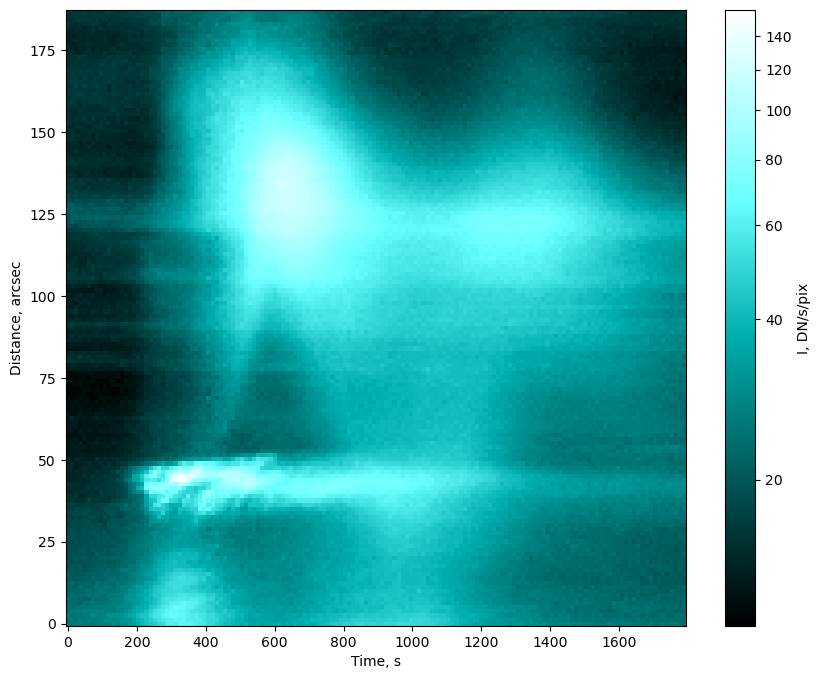

In [5]:
lines = [94, 131, 171, 193, 211, 304, 335]
l = lines[1]
time = np.arange(res[str(l)].shape[0])*12
# plt.pcolormesh(time, dist.value, res['131'].T,
#                norm=ImageNormalize(stretch=AsinhStretch()), cmap='sdoaia131')
fig, ax = plt.subplots(figsize=(10,8))
im = ax.pcolormesh(time, res['dist'], res[str(l)].T,
                   norm=ImageNormalize(stretch=AsinhStretch()), cmap=f'sdoaia{l}')
ax.set_xlabel('Time, s')
ax.set_ylabel('Distance, arcsec')
fig.colorbar(im, ax=ax, label='I, DN/s/pix')

In [6]:
from sites import *

t_min = 0.07e6
t_max = 30e6
n_bins = 48
channels = [k for k in res.keys() if k not in ['dist','w']]
# channels = ['131']
sites = SITES(t_min, t_max, n_bins, channels)

# for _ in tqdm(range(10000)):
#     dem, dem_err, err = sites.calc_dem(i, tol=0.01, max_iter=300)
print(np.unique([res[k].shape[0] for k in channels]))
nt,nx = np.unique([res[k].shape[0] for k in channels])[0], np.unique([res[k].shape[1] for k in channels])[0]
print(nt, nx)

temp_plot = np.zeros((nt, nx))
em_plot = np.zeros((nt, nx))

for i in range(nt):
    for j in range(nx):
        print(i,j)
        dem, err, dem_err = sites.calc_dem(np.array([res[k][j,i] for k in channels]), tol=0.01, max_iter=300)
        temp_plot[i,j] = sites.calc_temp(dem)
        em_plot[i,j] = sites.calc_em(dem)


[150]
150 150
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1

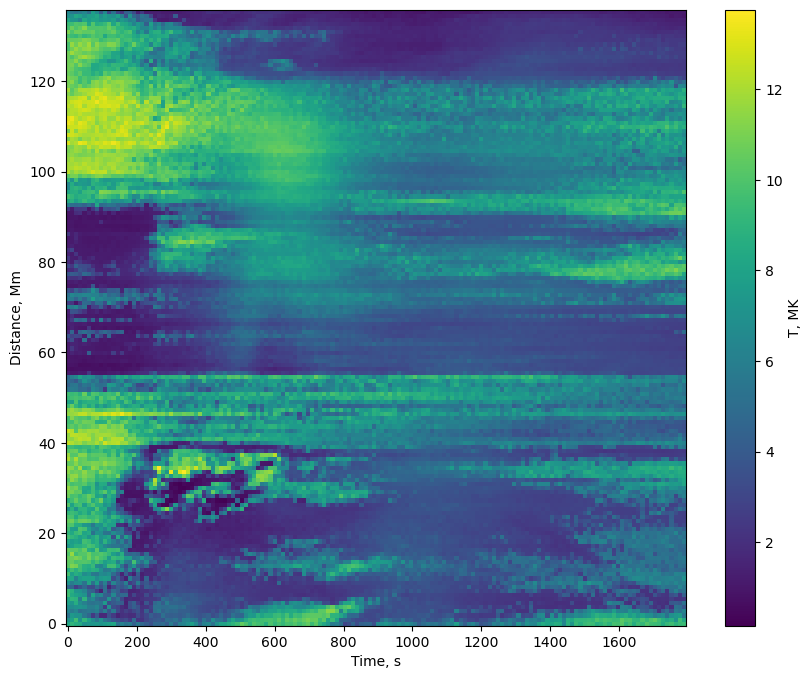

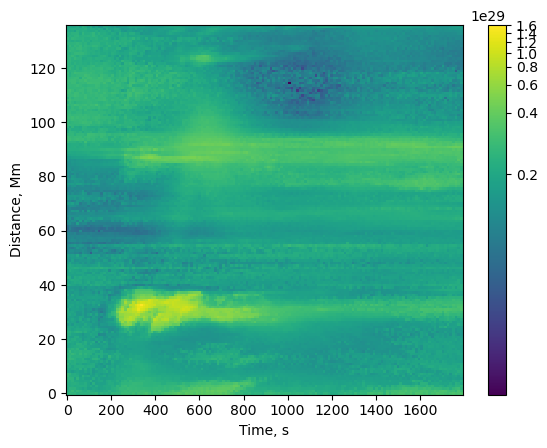

In [7]:
fig1, ax1 = plt.subplots(figsize=(10,8))
im1 = ax1.pcolormesh(time, dist, temp_plot/1e6)
ax1.set_xlabel('Time, s')
ax1.set_ylabel('Distance, Mm')
fig1.colorbar(im1, ax=ax1, label='T, MK')
plt.show()

fig2, ax2 = plt.subplots()
im2 = ax2.pcolormesh(time, dist, em_plot, norm=ImageNormalize(stretch=LogStretch()))
ax2.set_xlabel('Time, s')
ax2.set_ylabel('Distance, Mm')
fig2.colorbar(im2, ax=ax2)
plt.show()

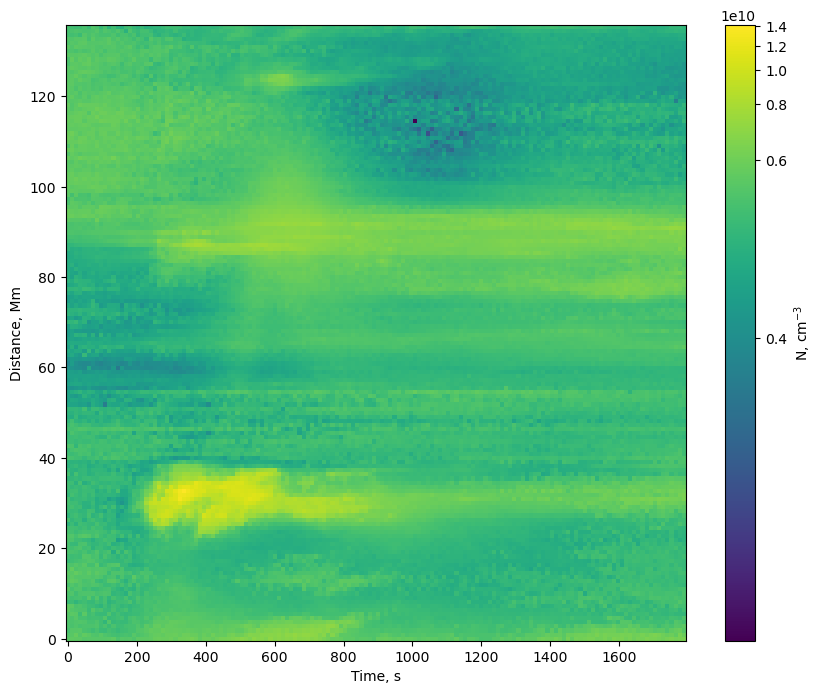

In [8]:
conc = np.sqrt(em_plot/width.to(u.cm).value)
fig1, ax1 = plt.subplots(figsize=(10,8))
im1 = ax1.pcolormesh(time, dist, conc, norm=ImageNormalize(stretch=LogStretch()))
ax1.set_xlabel('Time, s')
ax1.set_ylabel('Distance, Mm')
fig1.colorbar(im1, ax=ax1, label='N, cm$^{-3}$')
plt.show()

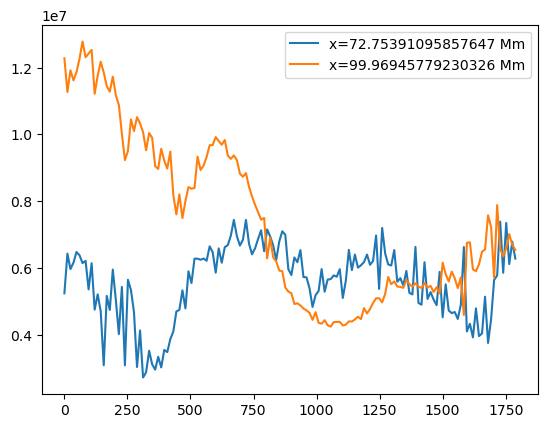

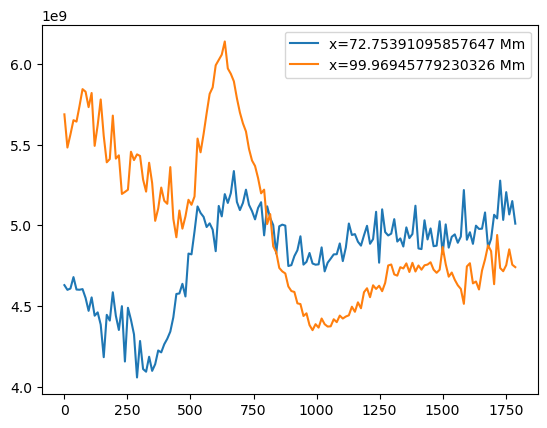

In [9]:
# plt.plot(time, np.sqrt(em_plot.T[240]/width.to(u.m).value))
# plt.plot(time, np.sqrt(em_plot.T[200]/width.to(u.m).value))
for i in range(80,len(dist)-20, 30):
    plt.plot(time, temp_plot[i], label=f'x={dist[i]}')
plt.legend()
plt.show()

for i in range(80,len(dist)-20, 30):
    plt.plot(time, conc[i], label=f'x={dist[i]}')
plt.legend()
plt.show()

In [10]:
tems = {'dist': dist, 'time': time, 'T': temp_plot, 'EM': em_plot, 'n': conc}
np.savez('final_tems_conc.npz', **tems)
